## Setup

In [2]:
import pandas as pd
from pprint import pprint
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Ingestion

In [3]:
df = pd.read_csv(r"data\raw\Train.csv")

## Data Preprocessing

### Analysing the data

Checking the data type and the null values in our data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [6]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

Checking unique values of balcony, total square feet, and size, for understanding what needs to be cleaned and analyse how to clean it.

In [7]:
columns = ['balcony', 'total_sqft', 'size']

for col in columns:
    unique_values = df[col].unique()
    print(f"Unique values for column '{col}': {unique_values}")

Unique values for column 'balcony': [ 1.  3. nan  2.  0.]
Unique values for column 'total_sqft': ['1056' '2600' '1440' ... '1133 - 1384' '774' '4689']
Unique values for column 'size': ['2 BHK' '4 Bedroom' '3 BHK' '4 BHK' '6 Bedroom' '3 Bedroom' '1 BHK'
 '1 RK' '1 Bedroom' '8 Bedroom' '2 Bedroom' '7 Bedroom' '5 BHK' '7 BHK'
 '6 BHK' '5 Bedroom' '11 BHK' '9 BHK' nan '9 Bedroom' '27 BHK'
 '10 Bedroom' '11 Bedroom' '10 BHK' '19 BHK' '16 BHK' '43 Bedroom'
 '14 BHK' '8 BHK' '12 Bedroom' '13 BHK' '18 Bedroom']


## Checking frequency of variables which have null values

This will show us which variables/variable ranges are more prominent in the market

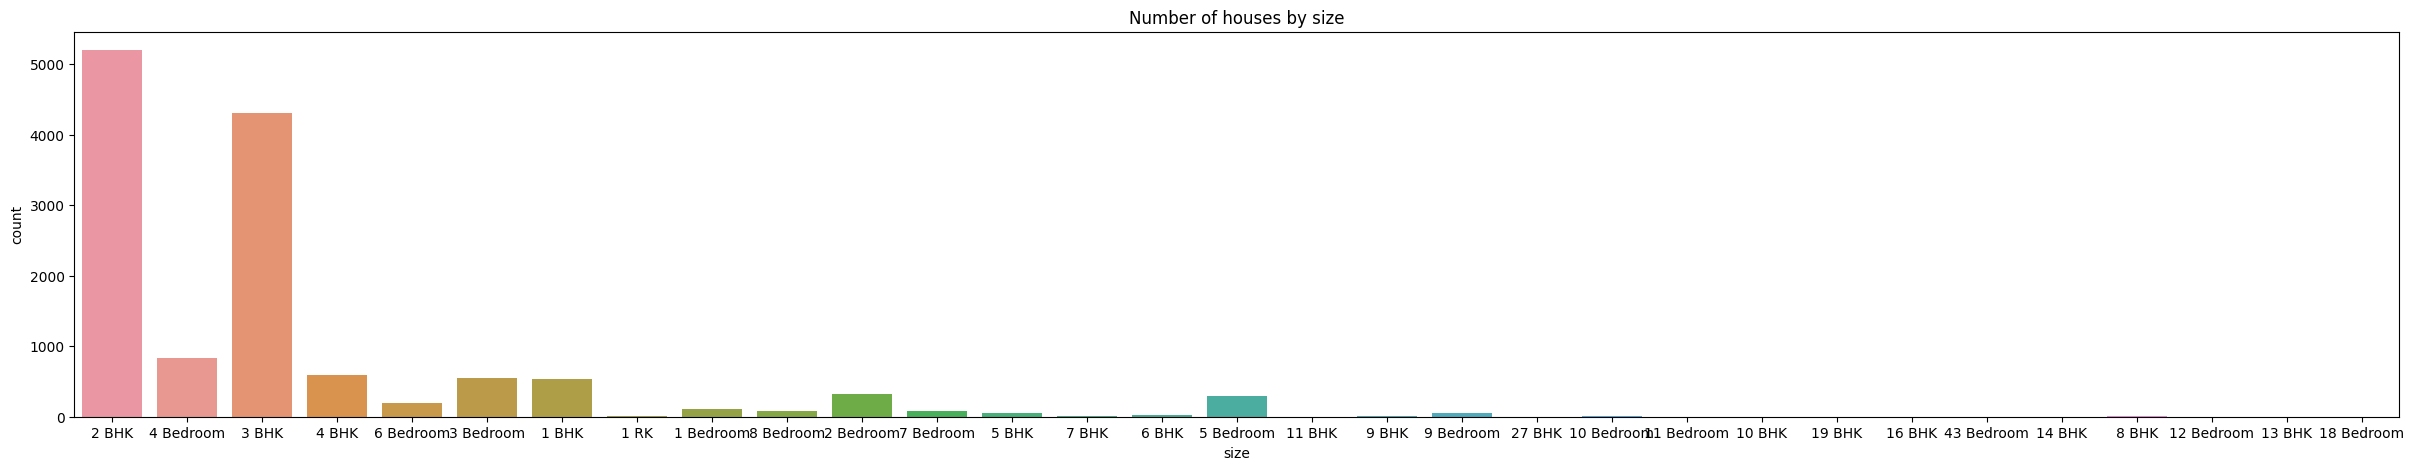

In [8]:
def size_plot(df,col):
    plt.figure(figsize=(30,5))
    sns.countplot(df, x=col)
    plt.title('Number of houses by size')

size_plot(df, 'size')

We see from the graph that most houses are 2BHK and 3BHK, but there are houses with 2/3 bed and bath mentioned as bedroom only so we will have to clean the data based on that and check again.

Spatial analysis using geopandas and geoplots to check location concentration 

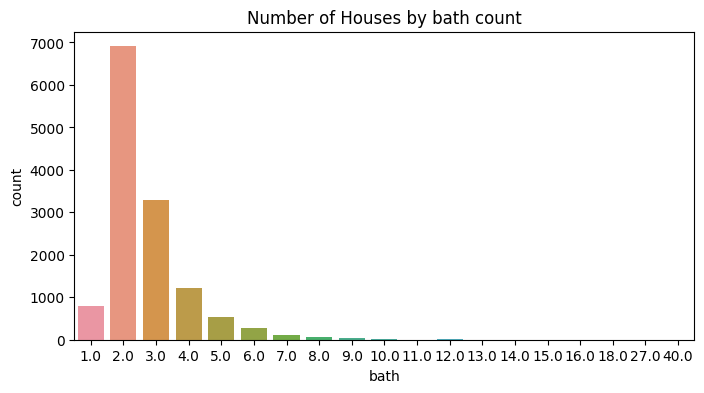

In [10]:
def bath_plot():
    plt.figure(figsize=(8,4))
    sns.countplot(x=df.bath)
    plt.title('Number of Houses by bath count')

bath_plot()

Bath count of 2 and 3 is most popular, with a few houses with 40 bathrooms!

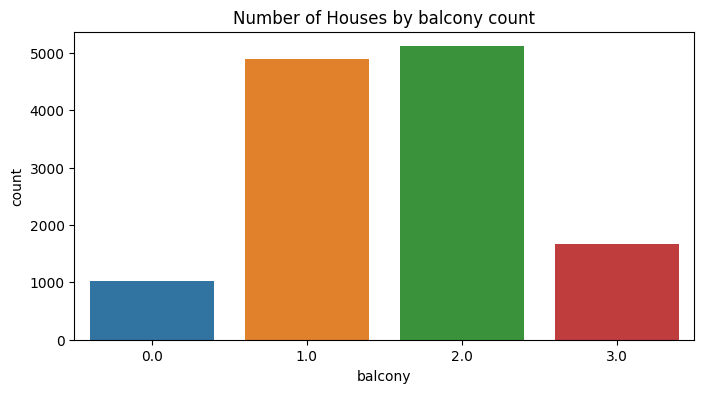

In [11]:
def balcony_plot():
    plt.figure(figsize=(8,4))
    sns.countplot(x=df.balcony)
    plt.title('Number of Houses by balcony count')

balcony_plot()

## Creating plots for other variables to check for other value range and count 

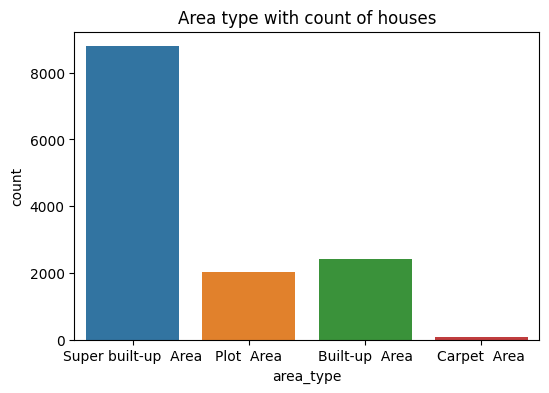

In [12]:
def areatype_plot():
    plt.figure(figsize=(6,4))
    sns.countplot(x=df.area_type)
    plt.title('Area type with count of houses')

areatype_plot()

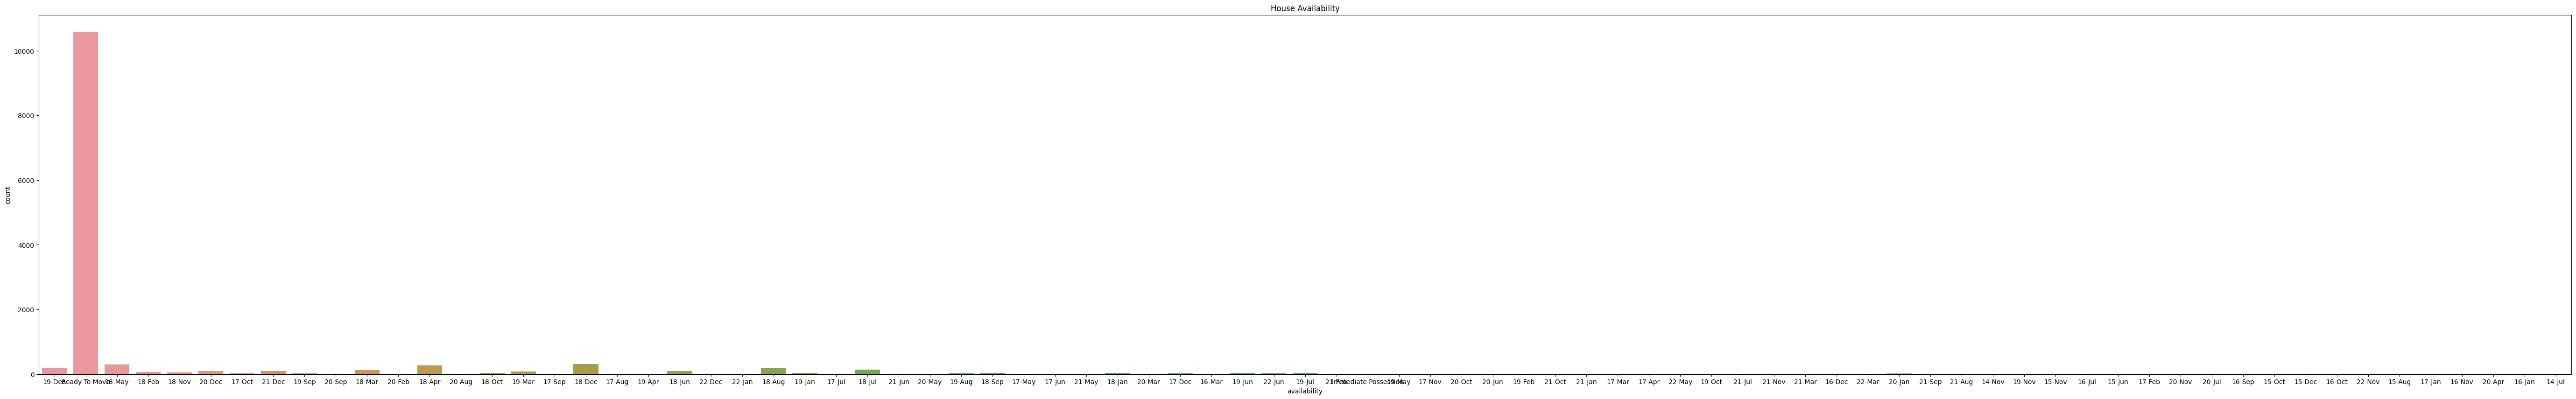

In [13]:
def availability_plot():
    plt.figure(figsize=(70,10))
    sns.countplot(x=df.availability)
    plt.title('House Availability')

availability_plot()

From this graph we see that max houses are offered as ready to move in, and the data is skewed to ready to move in houses.

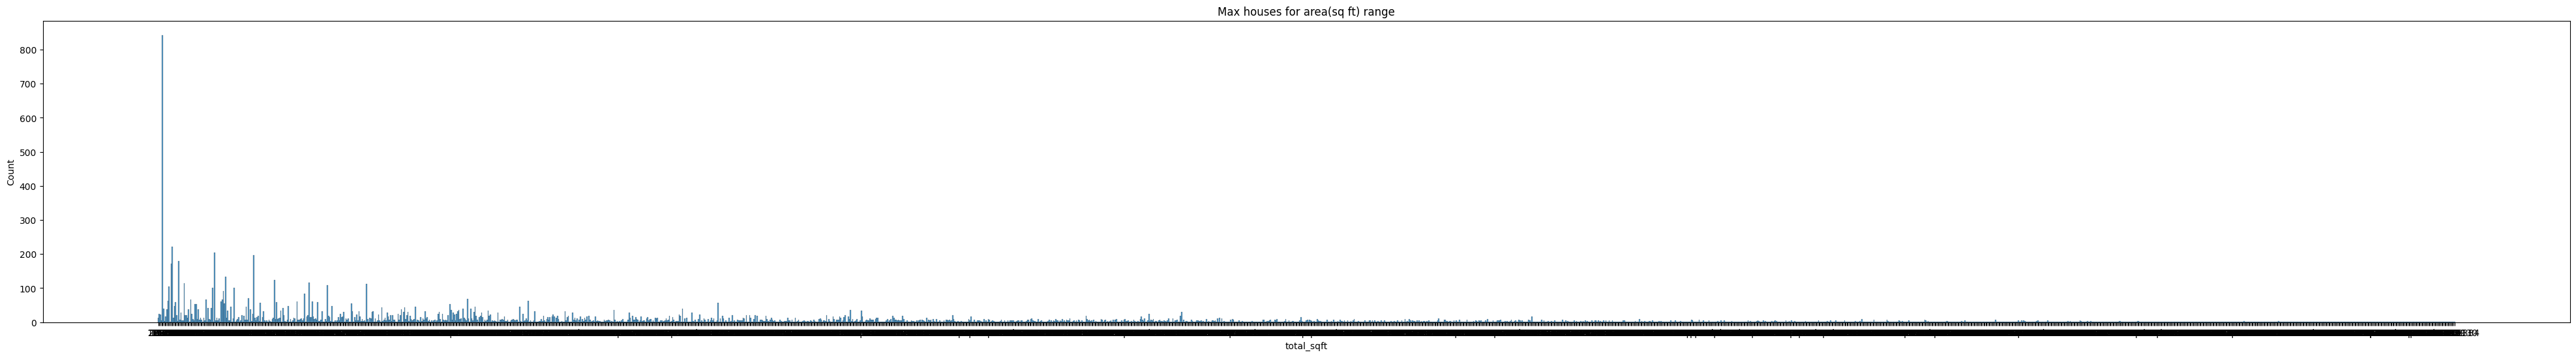

In [14]:
def sqft_plot():
    plt.figure(figsize=(50,6))
    sns.histplot(x=df.total_sqft, binwidth=5000)
    plt.title('Max houses for area(sq ft) range')

sqft_plot()

The total area in sq ft is also highly skewed we will have to clean it.
We also saw from the unique values that all values in this column weren't consistent, so will have to change that as well.

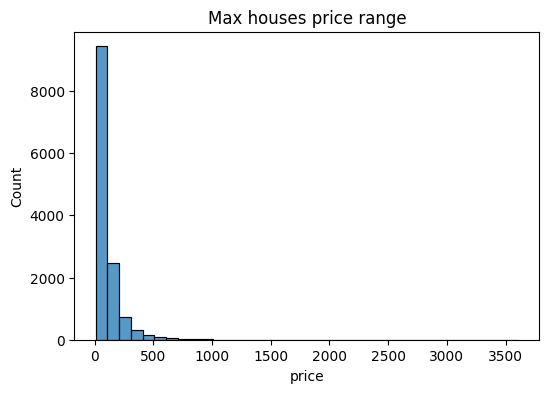

In [15]:
def price_plot():
    plt.figure(figsize=(6,4))
    sns.histplot(x=df.price, binwidth=100)
    plt.title('Max houses price range')

price_plot()

We can see that the price data is highly skewed, so we will have to remove the skewedness.

## Data Cleaning

Making a copy of our datframe to work on it

In [16]:
copy_df = df[['area_type', 'availability', 'location', 'size', 'society', 'total_sqft', 'bath', 
              'balcony', 'price']].copy()

Removed the words bedroom, bhk and rk from the size column as we saw from above that we need to do that and then created chart for better understanding of the values now.

In [17]:
def change(df, column):
    df[column] = df[column].astype(str).str.replace(' Bedroom', '').str.replace(' BHK', '').str.replace('RK', '')

change(copy_df, 'size')

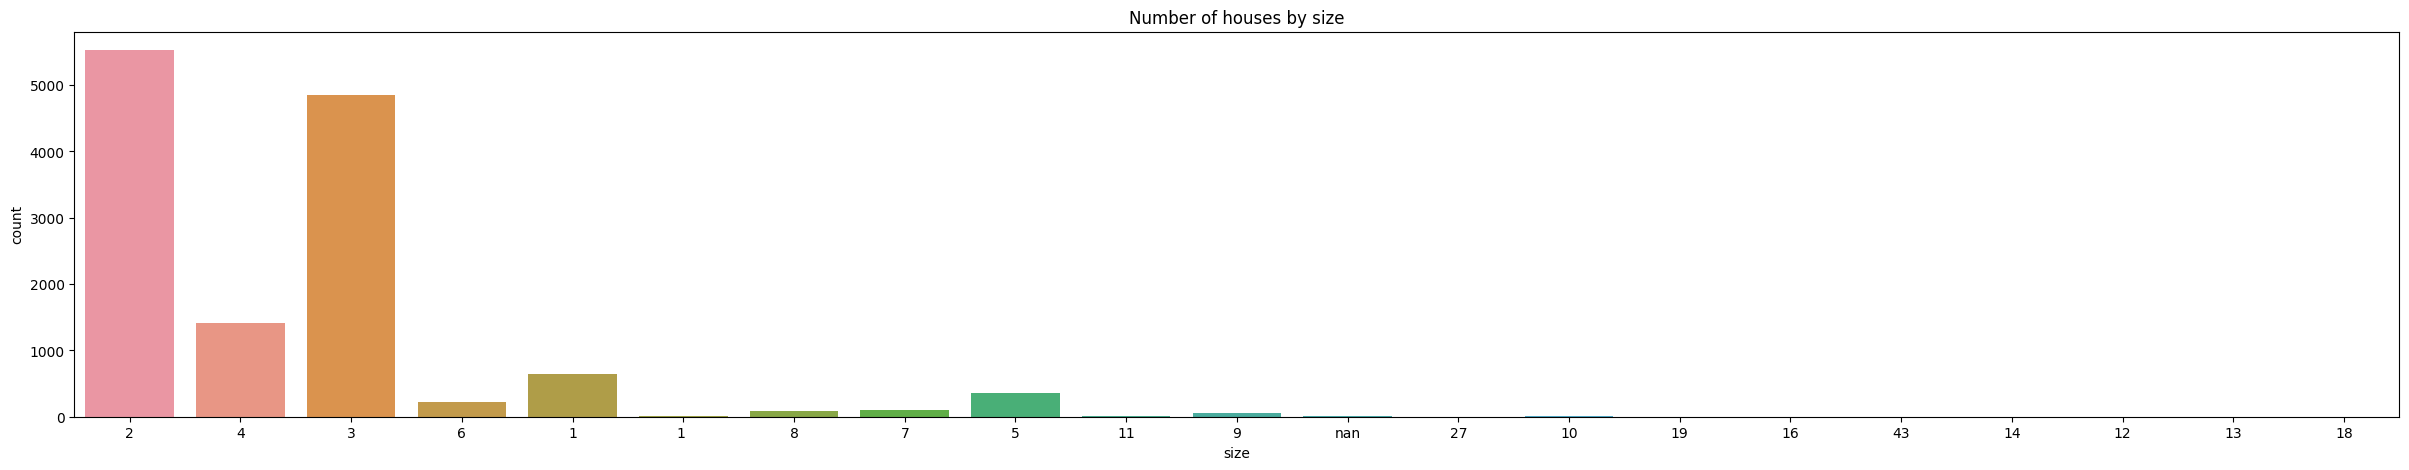

In [18]:
size_plot(copy_df, 'size')

2 BHK and 3 BHK have the highest number of houses 

Removing the null values in the data using mean, median, or a particular value, based on initial analysis.

In [20]:
def remove_null_values(df):
    df['size'].fillna(df['size'].astype(float).median(), inplace=True)
    df['size'] = df['size'].astype(float)

    df['society'].fillna('others', inplace=True)

    df['bath'].fillna(df['bath'].astype(float).median(), inplace=True)

    df['balcony'].fillna(df['balcony'].astype(float).median(), inplace=True)

    df['location'].fillna(df['location'].mode()[0], inplace=True)

remove_null_values(copy_df)

Removing skewdness of the data 

In [28]:
def remove_skew(df, column):
    df[column]=np.log1p(df[column])

remove_skew(copy_df, 'price')

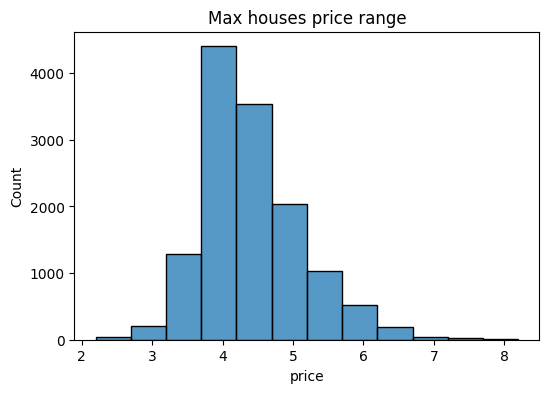

In [29]:
def price_plot():
    plt.figure(figsize=(6,4))
    sns.histplot(x=copy_df.price, binwidth=0.5)
    plt.title('Max houses price range')

price_plot()

In [30]:
def Total_sqft_average(value):
    if '-' in value:
        x, y = map(float, value.strip().split('-'))
        return (x + y) / 2
    return value

copy_df['total_sqft'] = copy_df['total_sqft'].apply(Total_sqft_average)

In [42]:
def extract_numeric(value):
    numeric_part = ''.join(filter(str.isdigit, value))
    return float(numeric_part) if numeric_part else None

In [46]:
def Total_sqft_convert(value):
    if 'acres' in str(value):
        acres = extract_numeric(value)
        if acres:
            sqft = acres * 43560
            return sqft
    elif 'Sq. Yards' in str(value):
        yards = extract_numeric(value)
        if yards:
            sqft = yards * 9
            return sqft
    elif 'Sq Meter' in str(value):
        sqmtr = extract_numeric(value)
        if sqmtr:
            sqft = sqmtr * 10.76
            return sqft
    elif 'Perch' in str(value):
        perch = extract_numeric(value)
        if perch:
            sqft = perch * 272
            return sqft
    elif 'Cents' in str(value):
        cent = extract_numeric(value)
        if cent:
            sqft = cent * 435.56
            return sqft
    elif 'Guntha' in str(value):
        guntha = extract_numeric(value)
        if guntha:
            sqft = guntha * 1089
            return sqft
    elif 'Ground' in str(value):
        ground = extract_numeric(value)
        if ground:
            sqft = ground * 2400
            return sqft
    return value

copy_df['total_sqft'] = copy_df['total_sqft'].apply(Total_sqft_convert)


## Creating Plots with Target Variable(Price)

Boxplot for area type and price dependency

Text(0.5, 1.0, 'Area Type vs Price')

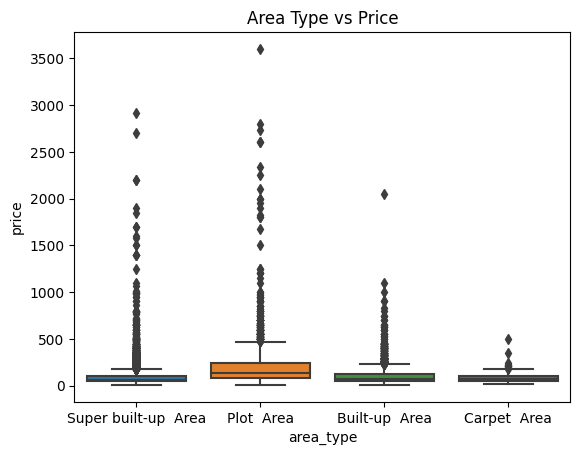

In [198]:
sns.boxplot(x = df['area_type'], y=df['price'])
plt.title('Area Type vs Price')

Scatterplot for availability and price dependency

Text(0.5, 1.0, 'Availability vs Price')

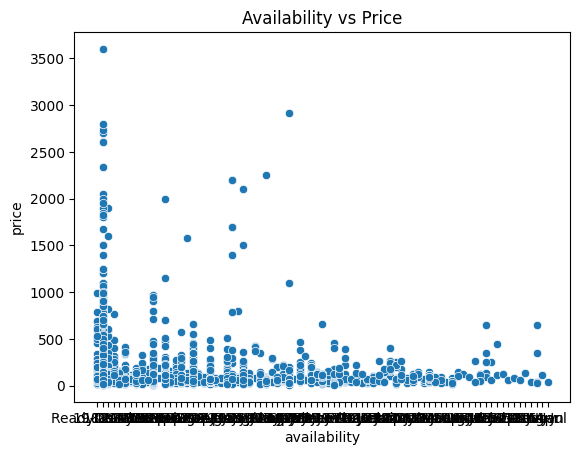

In [199]:
sns.scatterplot(x = df['availability'], y=df['price'])
plt.title('Availability vs Price')

Boxplot for size and price dependency

Text(0.5, 1.0, 'Size vs Price')

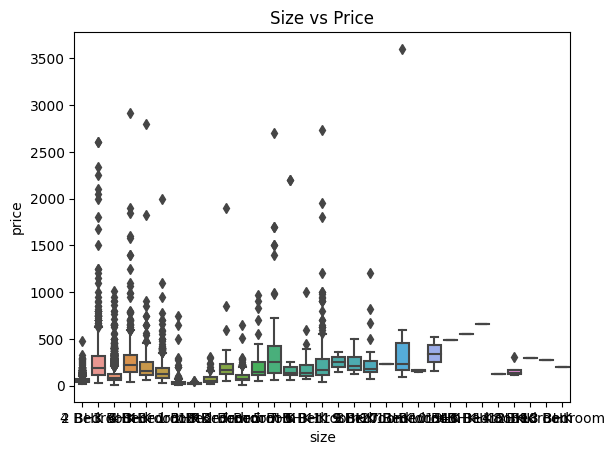

In [200]:
sns.boxplot(x = df['size'], y=df['price'])
plt.title('Size vs Price')

Boxplot for society and price dependency 

Text(0.5, 1.0, 'Society vs Price')

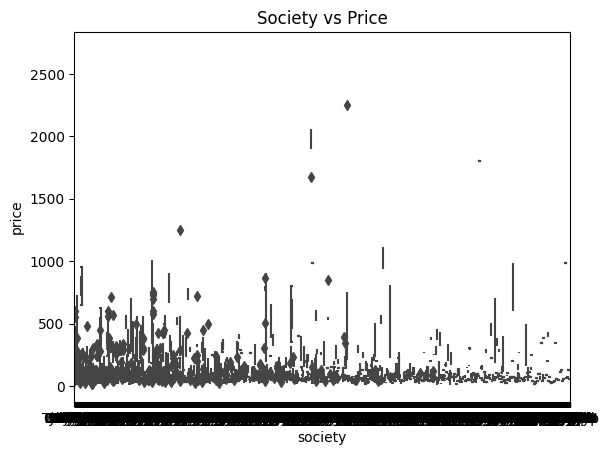

In [201]:
sns.boxplot(x = df['society'], y=df['price'])
plt.title('Society vs Price')

Scatterplot for total area in square ft and price dependency

Text(0.5, 1.0, 'Total area in sqft vs Price')

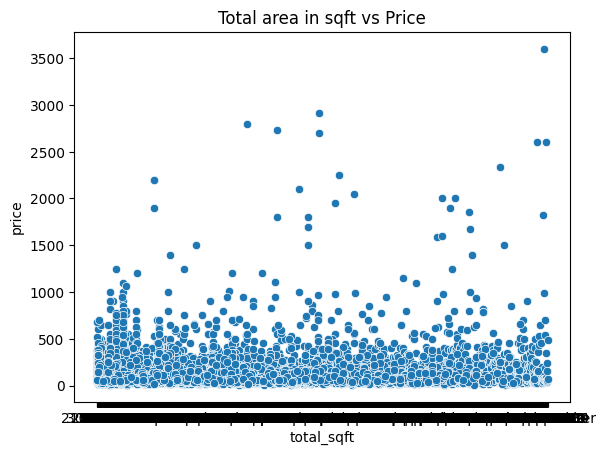

In [202]:
sns.scatterplot(x = df['total_sqft'], y=df['price'])
plt.title('Total area in sqft vs Price')

Boxplot for bath and price dependency 

Text(0.5, 1.0, 'Bath vs Price')

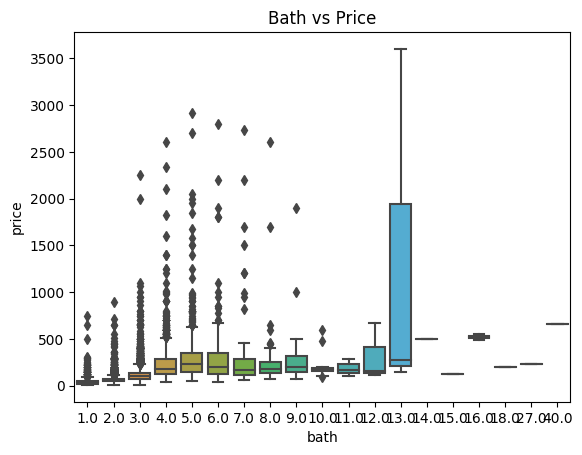

In [203]:
sns.boxplot(x = df['bath'], y=df['price'])
plt.title('Bath vs Price')

Boxplot for balcony and price dependency 

Text(0.5, 1.0, 'Balcony vs Price')

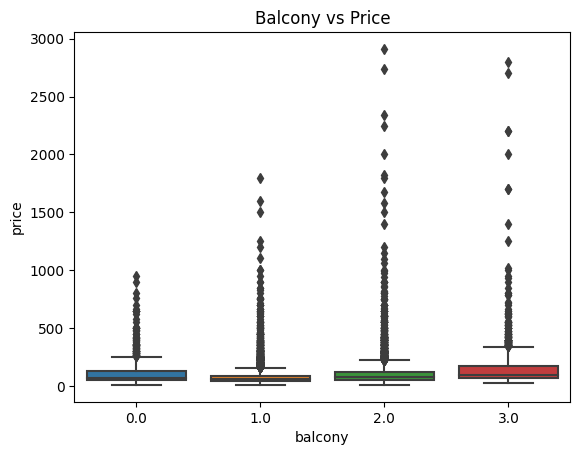

In [204]:
sns.boxplot(x = df['balcony'], y=df['price'])
plt.title('Balcony vs Price')